In [1]:
!pip install diffusers transformers accelerate scipy safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.9 MB/s eta 0:00:00


In [2]:
import cv2
from matplotlib import pyplot as plt
import PIL.Image as Image
import numpy as np


def crop_for_filling_pre(image: np.array, mask: np.array, crop_size: int = 512):
    # Calculate the aspect ratio of the image
    height, width = image.shape[:2]
    aspect_ratio = float(width) / float(height)

    # If the shorter side is less than 512, resize the image proportionally
    if min(height, width) < crop_size:
        if height < width:
            new_height = crop_size
            new_width = int(new_height * aspect_ratio)
        else:
            new_width = crop_size
            new_height = int(new_width / aspect_ratio)

        image = cv2.resize(image, (new_width, new_height))
        mask = cv2.resize(mask, (new_width, new_height))

    # Find the bounding box of the mask
    x, y, w, h = cv2.boundingRect(mask)

    # Update the height and width of the resized image
    height, width = image.shape[:2]

    # # If the 512x512 square cannot cover the entire mask, resize the image accordingly
    if w > crop_size or h > crop_size:
        # padding to square at first
        if height < width:
            padding = width - height
            image = np.pad(image, ((padding // 2, padding - padding // 2), (0, 0), (0, 0)), 'constant')
            mask = np.pad(mask, ((padding // 2, padding - padding // 2), (0, 0)), 'constant')
        else:
            padding = height - width
            image = np.pad(image, ((0, 0), (padding // 2, padding - padding // 2), (0, 0)), 'constant')
            mask = np.pad(mask, ((0, 0), (padding // 2, padding - padding // 2)), 'constant')

        resize_factor = crop_size / max(w, h)
        image = cv2.resize(image, (0, 0), fx=resize_factor, fy=resize_factor)
        mask = cv2.resize(mask, (0, 0), fx=resize_factor, fy=resize_factor)
        x, y, w, h = cv2.boundingRect(mask)

    # Calculate the crop coordinates
    crop_x = min(max(x + w // 2 - crop_size // 2, 0), width - crop_size)
    crop_y = min(max(y + h // 2 - crop_size // 2, 0), height - crop_size)

    # Crop the image
    cropped_image = image[crop_y:crop_y + crop_size, crop_x:crop_x + crop_size]
    cropped_mask = mask[crop_y:crop_y + crop_size, crop_x:crop_x + crop_size]

    return cropped_image, cropped_mask


def crop_for_filling_post(
        image: np.array,
        mask: np.array,
        filled_image: np.array,
        crop_size: int = 512,
        ):
    image_copy = image.copy()
    mask_copy = mask.copy()
    # Calculate the aspect ratio of the image
    height, width = image.shape[:2]
    height_ori, width_ori = height, width
    aspect_ratio = float(width) / float(height)

    # If the shorter side is less than 512, resize the image proportionally
    if min(height, width) < crop_size:
        if height < width:
            new_height = crop_size
            new_width = int(new_height * aspect_ratio)
        else:
            new_width = crop_size
            new_height = int(new_width / aspect_ratio)

        image = cv2.resize(image, (new_width, new_height))
        mask = cv2.resize(mask, (new_width, new_height))

    # Find the bounding box of the mask
    x, y, w, h = cv2.boundingRect(mask)

    # Update the height and width of the resized image
    height, width = image.shape[:2]

    # # If the 512x512 square cannot cover the entire mask, resize the image accordingly
    if w > crop_size or h > crop_size:
        flag_padding = True
        # padding to square at first
        if height < width:
            padding = width - height
            image = np.pad(image, ((padding // 2, padding - padding // 2), (0, 0), (0, 0)), 'constant')
            mask = np.pad(mask, ((padding // 2, padding - padding // 2), (0, 0)), 'constant')
            padding_side = 'h'
        else:
            padding = height - width
            image = np.pad(image, ((0, 0), (padding // 2, padding - padding // 2), (0, 0)), 'constant')
            mask = np.pad(mask, ((0, 0), (padding // 2, padding - padding // 2)), 'constant')
            padding_side = 'w'

        resize_factor = crop_size / max(w, h)
        image = cv2.resize(image, (0, 0), fx=resize_factor, fy=resize_factor)
        mask = cv2.resize(mask, (0, 0), fx=resize_factor, fy=resize_factor)
        x, y, w, h = cv2.boundingRect(mask)
    else:
        flag_padding = False

    # Calculate the crop coordinates
    crop_x = min(max(x + w // 2 - crop_size // 2, 0), width - crop_size)
    crop_y = min(max(y + h // 2 - crop_size // 2, 0), height - crop_size)

    # Fill the image
    image[crop_y:crop_y + crop_size, crop_x:crop_x + crop_size] = filled_image
    if flag_padding:
        image = cv2.resize(image, (0, 0), fx=1/resize_factor, fy=1/resize_factor)
        if padding_side == 'h':
            image = image[padding // 2:padding // 2 + height_ori, :]
        else:
            image = image[:, padding // 2:padding // 2 + width_ori]

    image = cv2.resize(image, (width_ori, height_ori))

    image_copy[mask_copy==255] = image[mask_copy==255]
    return image_copy

def dilate_mask(mask, dilate_factor=50):
    mask = mask.astype(np.uint8)
    mask = cv2.dilate(
        mask,
        np.ones((dilate_factor, dilate_factor), np.uint8),
        iterations=1
    )
    return mask

## Image Generation Using Stable Diffusion

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

model_id = "runwayml/stable-diffusion-v1-5"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

In [ ]:
prompt = "Create an image capturing indian road having the perspective from a car's frontal viewpoint, that's inclined at a 45-degree angle. Make the scene feel immersive and natural with stable diffusion for realistic lighting."
image = pipe(prompt).images[0]

image.save("o_downstream_0_cpa.png")


  0%|          | 0/50 [00:00<?, ?it/s]

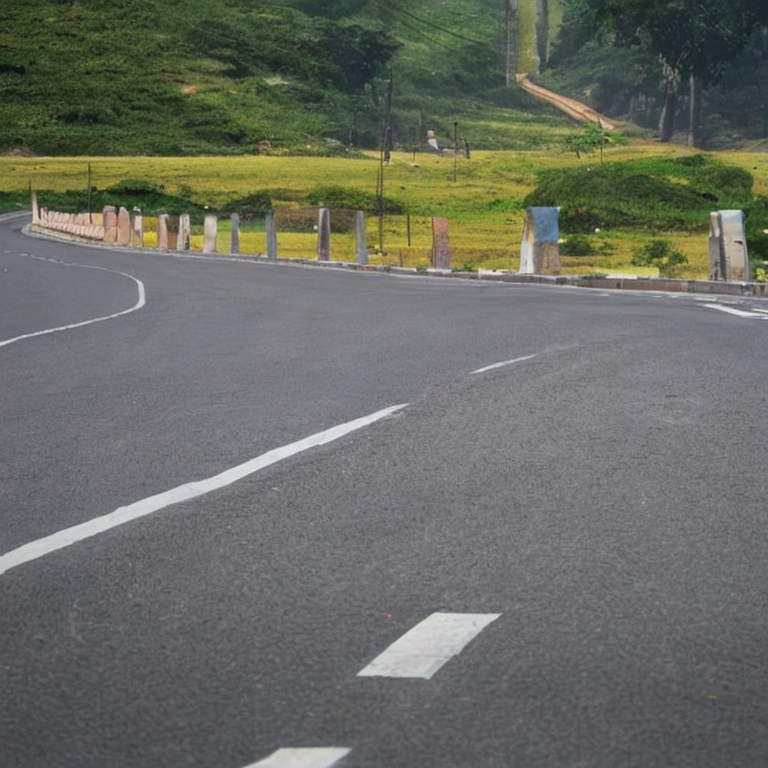

In [10]:
image

## Adding Object using Stable Diffusion - Inpaiting

In [11]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float32,
    ).to("cuda")

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
#img = np.array(image)
img = cv2.imread("set1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Gen 1

In [6]:
text_prompt = "front right view of an indian bus on the road"
start_point = (23,240)
end_point = (256,446)

mask_image = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
# img = cv2.rectangle(img, start_point, end_point, (255,0,0), -1)
mask = cv2.rectangle(mask_image, start_point, end_point, 255, -1)
# mask = cv2.circle(mask_image, (577,514), 150, 255, -1)
mask = dilate_mask(mask)
# PIL.Image.fromarray(mask)

In [12]:

img_crop, mask_crop = crop_for_filling_pre(img, mask)
img_crop_filled = inpaint_pipe(
    prompt=text_prompt,
    image=Image.fromarray(img_crop),
    mask_image=Image.fromarray(mask_crop)
).images[0]
img_filled = crop_for_filling_post(img, mask, np.array(img_crop_filled))


  0%|          | 0/50 [00:00<?, ?it/s]

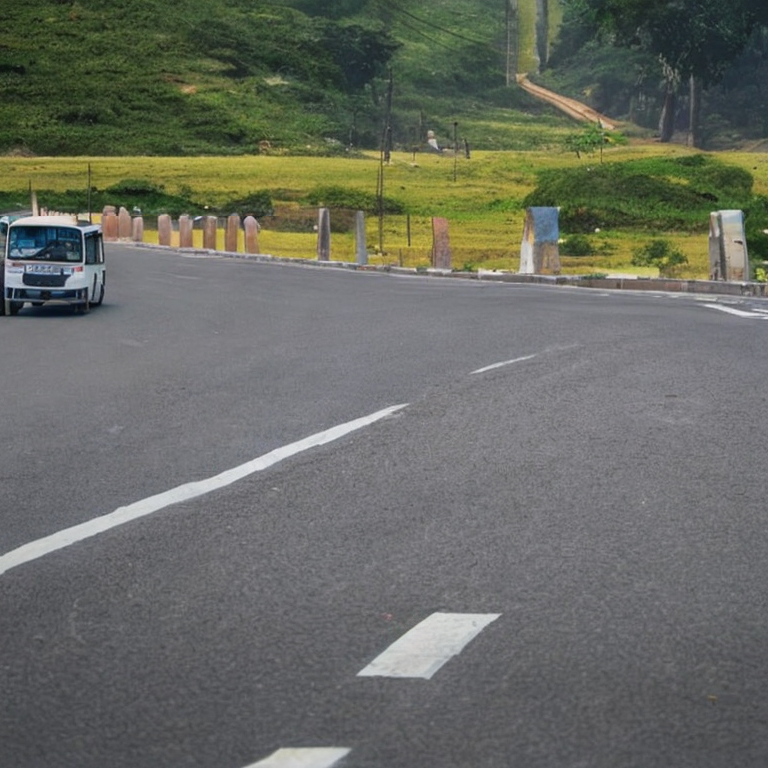

In [13]:
PIL.Image.fromarray(img_filled)

  0%|          | 0/50 [00:00<?, ?it/s]

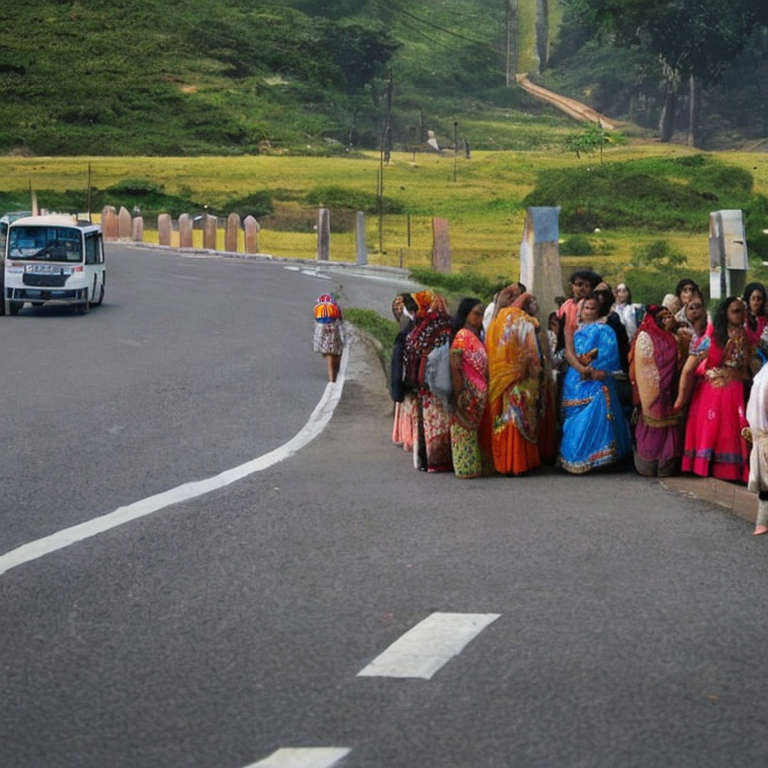

In [15]:
text_prompt = "a medium crowd wearing indian dress waiting for the bus"
start_point = (304,290)
end_point = (750,562)

mask_image = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
# img = cv2.rectangle(img, start_point, end_point, (255,0,0), -1)
mask = cv2.rectangle(mask_image, start_point, end_point, 255, -1)
# mask = cv2.circle(mask_image, (577,514), 150, 255, -1)
mask = dilate_mask(mask)
# PIL.Image.fromarray(mask)

img_crop, mask_crop = crop_for_filling_pre(img_filled, mask)
img_crop_filled = inpaint_pipe(
    prompt=text_prompt,
    image=Image.fromarray(img_crop),
    mask_image=Image.fromarray(mask_crop)
).images[0]
img_filled = crop_for_filling_post(img, mask, np.array(img_crop_filled))

PIL.Image.fromarray(img_filled)

### Gen 2

In [36]:
#img = np.array(image)
img = cv2.imread("set1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  0%|          | 0/50 [00:00<?, ?it/s]

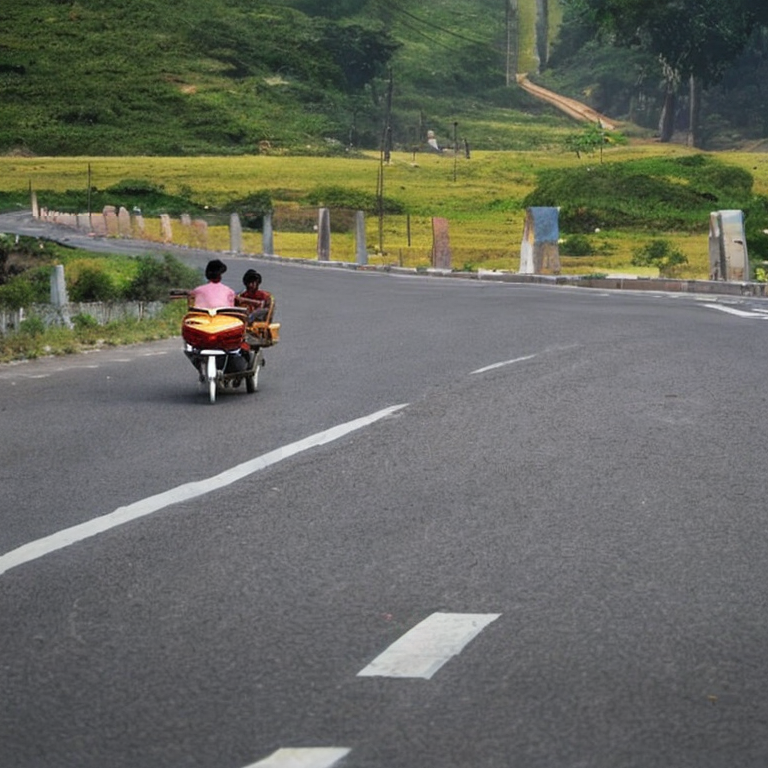

In [37]:
text_prompt = "an indian three wheeler vehicle on the road"
start_point = (23,240)
end_point = (256,446)

mask_image = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
mask = cv2.rectangle(mask_image, start_point, end_point, 255, -1)
mask = dilate_mask(mask)

img_crop, mask_crop = crop_for_filling_pre(img, mask)
img_crop_filled = inpaint_pipe(
    prompt=text_prompt,
    image=Image.fromarray(img_crop),
    mask_image=Image.fromarray(mask_crop)
).images[0]
img_filled1 = crop_for_filling_post(img, mask, np.array(img_crop_filled))

PIL.Image.fromarray(img_filled1)

  0%|          | 0/50 [00:00<?, ?it/s]

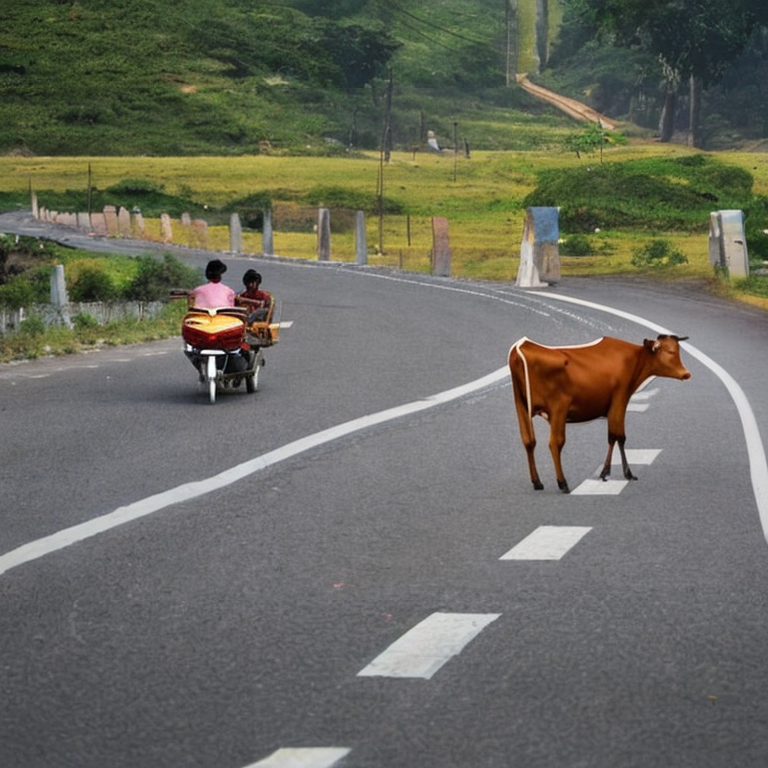

In [39]:
text_prompt = "Cow crossing the road, preserve background"
start_point = (304,290)
end_point = (750,562)

mask_image = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
# img = cv2.rectangle(img, start_point, end_point, (255,0,0), -1)
mask = cv2.rectangle(mask_image, start_point, end_point, 255, -1)
# mask = cv2.circle(mask_image, (577,514), 150, 255, -1)
mask = dilate_mask(mask)


img_crop, mask_crop = crop_for_filling_pre(img, mask)
img_crop_filled = inpaint_pipe(
    prompt=text_prompt,
    image=Image.fromarray(img_crop),
    mask_image=Image.fromarray(mask_crop)
).images[0]
img_filled1 = crop_for_filling_post(img, mask, np.array(img_crop_filled))

PIL.Image.fromarray(img_filled1)

### Gen3

In [46]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

model_id = "runwayml/stable-diffusion-v1-5"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

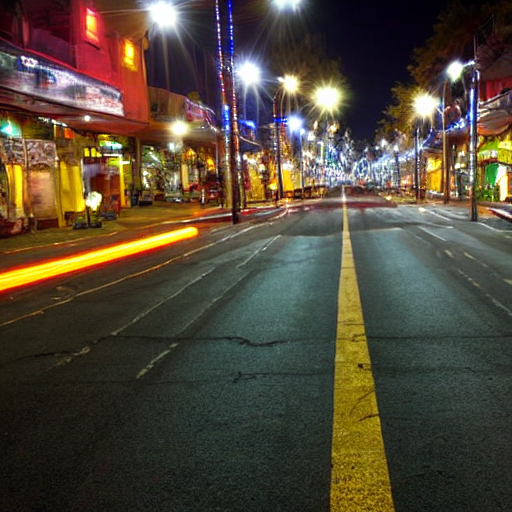

In [62]:

prompt = "Create an image an indian street road in the night, capturing the perspective from a car's frontal viewpoint. There should not be any vehicle on the road. Make image real world. without light rails. Only stree lights as ligh source "
image = pipe(prompt).images[0]
image

In [74]:
image.save("night_rain_set2.png")

In [80]:
image.save("twilight_fogy_set2.png")

  0%|          | 0/50 [00:00<?, ?it/s]

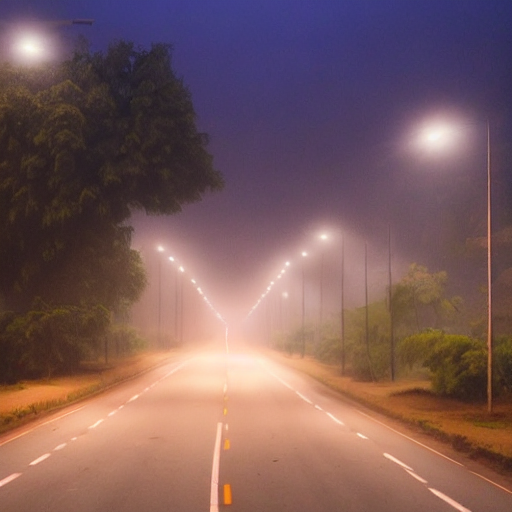

In [79]:

prompt = "Create an image an indian road in the evening having fog, capturing the perspective from a car's frontal viewpoint. There should not be any vehicle on the road. Make image real world."
image = pipe(prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

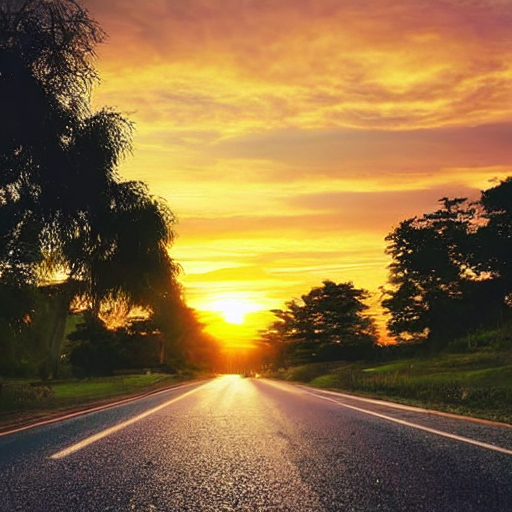

In [83]:

prompt = "Create an image an indian road in the evening with sunset, capturing the perspective from a car's frontal viewpoint. There should not be any vehicle on the road. Make image real world."
image = pipe(prompt).images[0]
image

In [84]:
image.save("twilight_set2.png")

### Gen4

In [69]:
img = np.array(image)

  0%|          | 0/50 [00:00<?, ?it/s]

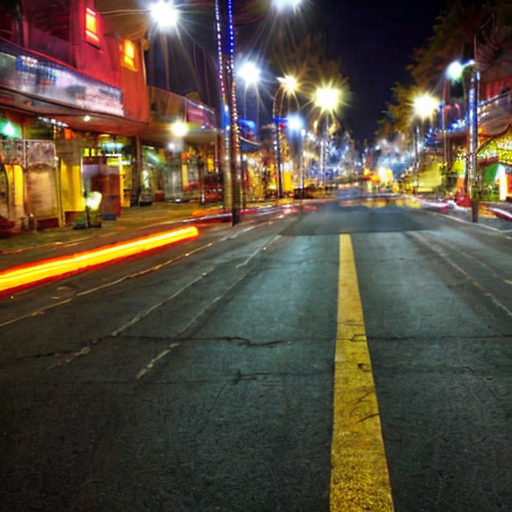

In [85]:
text_prompt = "a large dog walking on the road"
start_point = (349,186)
end_point = (442,273)

mask_image = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
# img = cv2.rectangle(img, start_point, end_point, (255,0,0), -1)
mask = cv2.rectangle(mask_image, start_point, end_point, 255, -1)
# mask = cv2.circle(mask_image, (577,514), 150, 255, -1)
mask = dilate_mask(mask)
# PIL.Image.fromarray(mask)

img_crop, mask_crop = crop_for_filling_pre(img, mask)
img_crop_filled = inpaint_pipe(
    prompt=text_prompt,
    image=Image.fromarray(img_crop),
    mask_image=Image.fromarray(mask_crop)
).images[0]
img_filled = crop_for_filling_post(img, mask, np.array(img_crop_filled))

PIL.Image.fromarray(img_filled)

In [86]:
img = cv2.imread("set1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  0%|          | 0/50 [00:00<?, ?it/s]

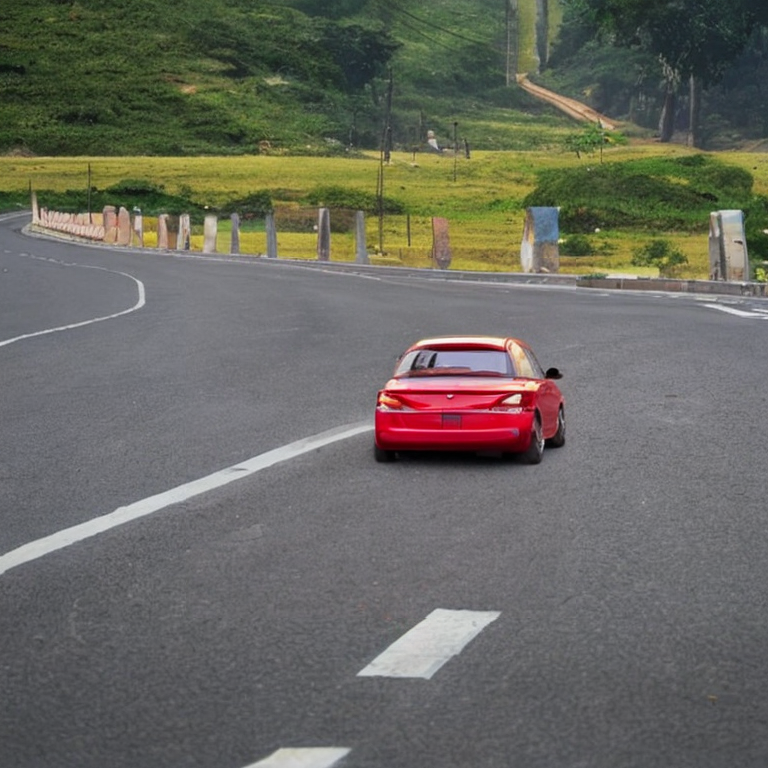

In [87]:
text_prompt = "a red car on the road"
start_point = (210,282)
end_point = (550,592)

mask_image = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
# img = cv2.rectangle(img, start_point, end_point, (255,0,0), -1)
mask = cv2.rectangle(mask_image, start_point, end_point, 255, -1)
# mask = cv2.circle(mask_image, (577,514), 150, 255, -1)
mask = dilate_mask(mask)
# PIL.Image.fromarray(mask)

img_crop, mask_crop = crop_for_filling_pre(img, mask)
img_crop_filled = inpaint_pipe(
    prompt=text_prompt,
    image=Image.fromarray(img_crop),
    mask_image=Image.fromarray(mask_crop)
).images[0]
img_filled = crop_for_filling_post(img, mask, np.array(img_crop_filled))

PIL.Image.fromarray(img_filled)

In [94]:
img = cv2.imread("/content/noon_rain_set2.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
text_prompt = "a red car on the road"
start_point = (210,282)
end_point = (550,592)

mask_image = np.zeros((img.shape[0], img.shape[1]), dtype = np.uint8)
# img = cv2.rectangle(img, start_point, end_point, (255,0,0), -1)
mask = cv2.rectangle(mask_image, start_point, end_point, 255, -1)
# mask = cv2.circle(mask_image, (577,514), 150, 255, -1)
mask = dilate_mask(mask)
# PIL.Image.fromarray(mask)

img_crop, mask_crop = crop_for_filling_pre(img, mask)
img_crop_filled = inpaint_pipe(
    prompt=text_prompt,
    image=Image.fromarray(img_crop),
    mask_image=Image.fromarray(mask_crop)
).images[0]
img_filled = crop_for_filling_post(img, mask, np.array(img_crop_filled))

PIL.Image.fromarray(img_filled)

  0%|          | 0/50 [00:00<?, ?it/s]